In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

In [2]:
%store -r customer_indicators

# Clustering

### Pre-processing

In [3]:
rfm_log = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
rfm_log['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
rfm_log['Recency'] = customer_indicators[['Recency']]#.apply(np.log10, axis=1).round(3)

rfm_k = rfm_log[['Delta', 'Recency', 'RMonetary']]
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm_k.values)

## K-means

In [4]:
sse = []
silhouette = []
kmax = 7
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled, kmeans.labels_))

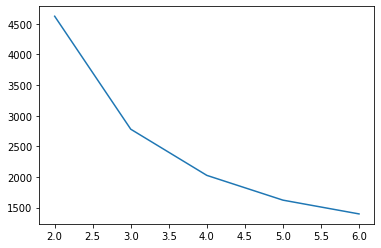

In [5]:
# Elbow curve.
ax = plt.plot(range(2, kmax), sse)
plt.show()

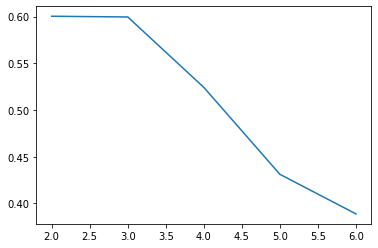

In [6]:
# Silhouette score.
ax = plt.plot(range(2, kmax), silhouette)
plt.show()

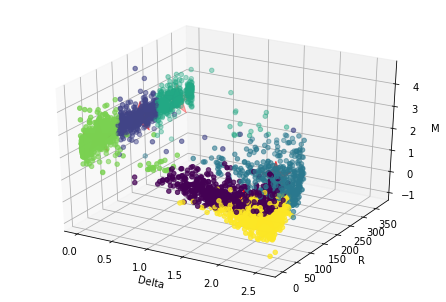

In [7]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_x = centers[:,0]
centroids_y = centers[:,1]
centroids_z = centers[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Delta'], rfm_log['Recency'], rfm_log['RMonetary'], c=kmeans.labels_)
ax.scatter(centroids_x,centroids_y,centroids_z,s=1000, marker='*', c='r')
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

### Post-processing

In [8]:
# create column containing cluster label
rfm_log['Behavior'] = kmeans.labels_
rfm_log.head()

,RMonetary,Delta,Recency,Behavior
0,1.071,2.563,2,0
1,0.706,2.452,75,5
2,3.164,0.000,19,4
3,2.469,0.000,310,3
4,0.725,2.417,36,5


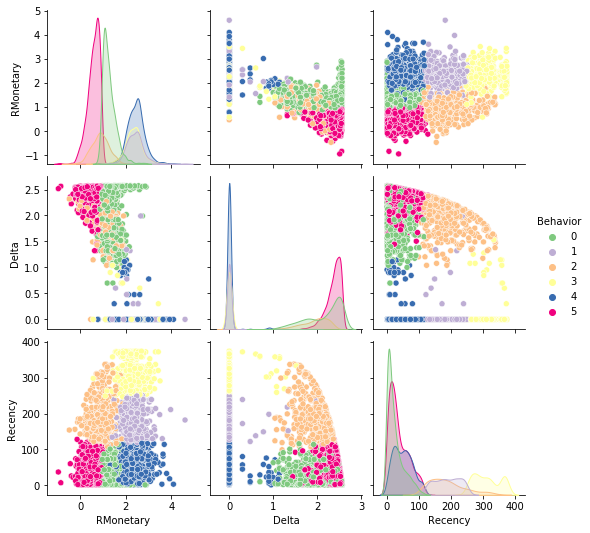

In [9]:
sns.pairplot(data = rfm_log, hue = "Behavior", palette = "Accent")
plt.show()

In [10]:
clusters = list()
for i in range(0,6):
    clusters.append(rfm_log[rfm_log['Behavior'] == i])

In [11]:
for i in range(0,len(clusters)):
    print(clusters[i].describe())

         RMonetary        Delta      Recency  Behavior
count  1041.000000  1041.000000  1041.000000    1041.0
mean      1.266954     2.157811    24.717579       0.0
std       0.291855     0.407631    24.814755       0.0
min       0.772000     0.699000     1.000000       0.0
25%       1.059000     1.845000     5.000000       0.0
50%       1.197000     2.314000    16.000000       0.0
75%       1.403000     2.515000    36.000000       0.0
max       2.897000     2.573000   116.000000       0.0
        RMonetary       Delta     Recency  Behavior
count  396.000000  396.000000  396.000000     396.0
mean     2.396101    0.020245  188.113636       1.0
std      0.373190    0.155427   38.452400       0.0
min      1.176000    0.000000  119.000000       1.0
25%      2.153500    0.000000  155.750000       1.0
50%      2.393000    0.000000  189.000000       1.0
75%      2.586500    0.000000  219.000000       1.0
max      4.601000    1.991000  250.000000       1.0
        RMonetary       Delta     Rec

## DBSCAN

In [12]:
# Random parameters selection
density = DBSCAN(eps=0.2, min_samples=5).fit(scaled)
labels = density.labels_
labels

array([0, 0, 1, ..., 0, 0, 0])

In [13]:
dbscan_df = rfm_log.copy()
del dbscan_df['Behavior']
dbscan_df["label"] = labels

/home/alessio/.local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/alessio/.local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


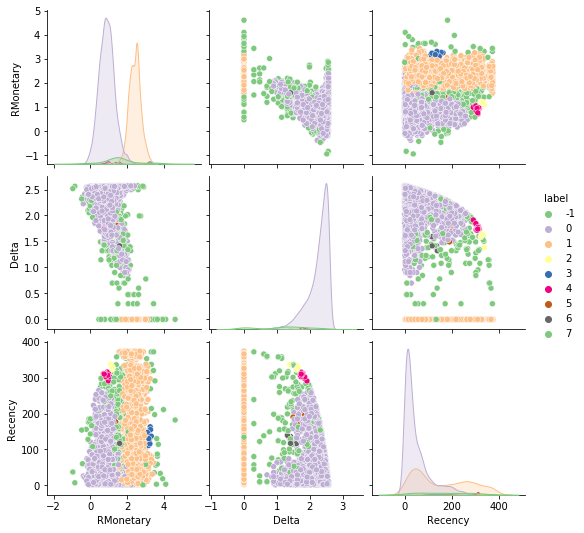

In [14]:
sns.pairplot(data = dbscan_df, hue = "label", palette = "Accent")
plt.show()

## Grid search

In [15]:
eps_to_test = [round(eps,1) for eps in np.arange(0.1, 2, 0.1)]
min_samples_to_test = range(5, 50, 5)

In [16]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting
    dbscan_model_ = DBSCAN(eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [17]:
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test), len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [18]:
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, scaled, iter_)
        
        # Inserisco i risultati nei relativi dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.1 and min_samples =   5 | 0.175   24
  2 | Tested with eps = 0.1 and min_samples =  10 | 0.138   20
  3 | Tested with eps = 0.1 and min_samples =  15 | 0.117   11
  4 | Tested with eps = 0.1 and min_samples =  20 | 0.106    6
  5 | Tested with eps = 0.1 and min_samples =  25 | 0.099    2
  6 | Tested with eps = 0.1 and min_samples =  30 | 0.096    4
  7 | Tested with eps = 0.1 and min_samples =  35 | 0.092    4
  8 | Tested with eps = 0.1 and min_samples =  40 | 0.088    1
  9 | Tested with eps = 0.1 and min_samples =  45 | 0.087    1
 10 | Tested with eps = 0.2 and min_samples =   5 | 0.325    8
 11 | Tested with eps = 0.2 and min_samples =  10 | 0.255    4
 12 | Tested with eps = 0.2 and min_samples =  15 | 0.218    3
 13 | Tested with eps = 0.2 and min_samples =  20 | 0.192    2
 14 | Tested with eps = 0.2 and min_samples =  25

129 | Tested with eps = 1.5 and min_samples =  15 |  None    1
130 | Tested with eps = 1.5 and min_samples =  20 |  None    1
131 | Tested with eps = 1.5 and min_samples =  25 |  None    1
132 | Tested with eps = 1.5 and min_samples =  30 |  None    1
133 | Tested with eps = 1.5 and min_samples =  35 |  None    1
134 | Tested with eps = 1.5 and min_samples =  40 |  None    1
135 | Tested with eps = 1.5 and min_samples =  45 |  None    1
136 | Tested with eps = 1.6 and min_samples =   5 |  None    1
137 | Tested with eps = 1.6 and min_samples =  10 |  None    1
138 | Tested with eps = 1.6 and min_samples =  15 |  None    1
139 | Tested with eps = 1.6 and min_samples =  20 |  None    1
140 | Tested with eps = 1.6 and min_samples =  25 |  None    1
141 | Tested with eps = 1.6 and min_samples =  30 |  None    1
142 | Tested with eps = 1.6 and min_samples =  35 |  None    1
143 | Tested with eps = 1.6 and min_samples =  40 |  None    1
144 | Tested with eps = 1.6 and min_samples =  45 |  No

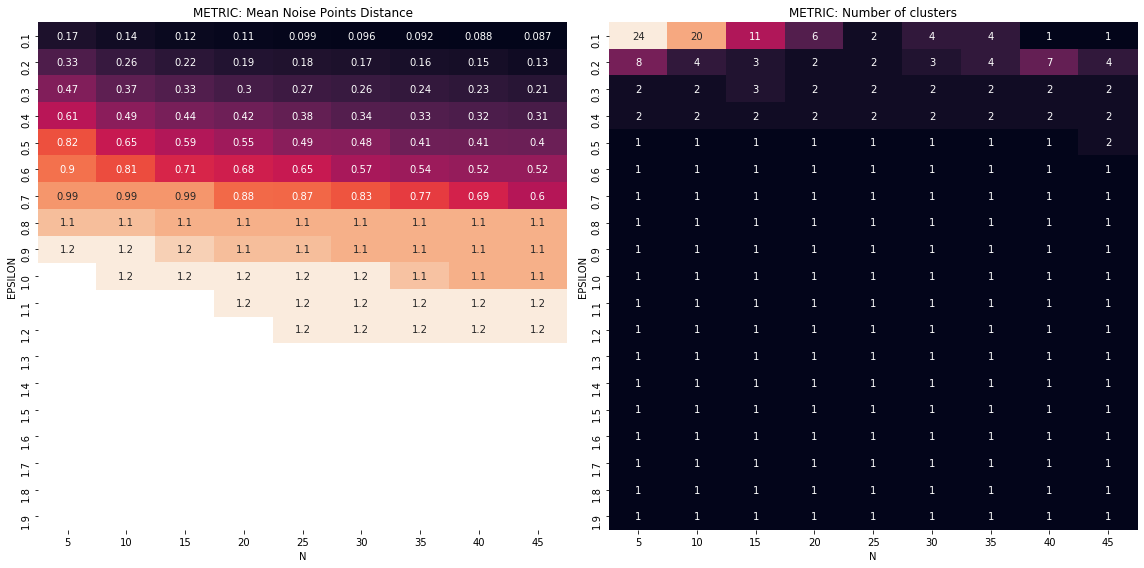

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [20]:
# Best parameters
density = DBSCAN(eps=0.4, min_samples=5).fit(scaled)
labels = density.labels_

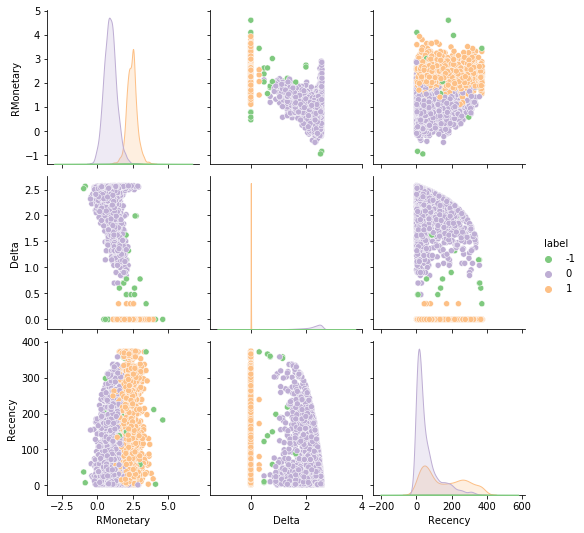

In [21]:
dbscan_df["label"] = labels
sns.pairplot(data=dbscan_df, hue="label", palette="Accent")
plt.show()

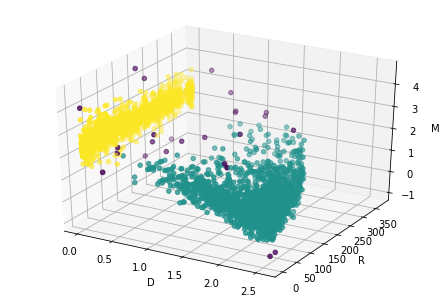

In [22]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Delta'], rfm_log['Recency'], rfm_log['RMonetary'], c=density.labels_)
ax.set_xlabel('D')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

# Hierarchical

In [23]:
rfm_log = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
rfm_log['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
rfm_log['Recency'] = customer_indicators[['Recency']]#.apply(np.log10, axis=1).round(3)

rfm_k = rfm_log[['Delta', 'Recency', 'RMonetary']]
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm_k.values)

data_scaled = pd.DataFrame(scaled, columns=rfm_log.columns)

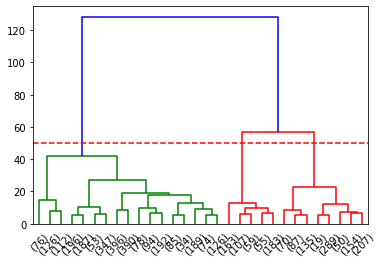

In [24]:
data_dist = pdist(scaled, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=50, color='r', linestyle='--')

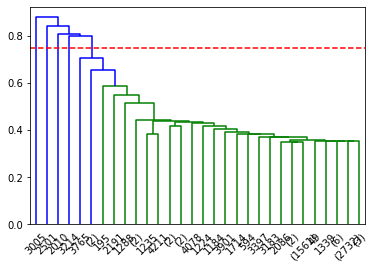

In [25]:
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=0.75, color='r', linestyle='--')

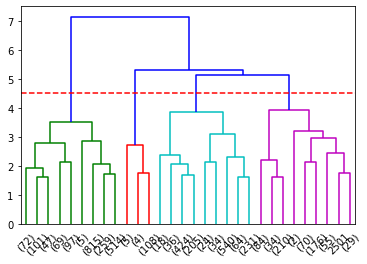

In [26]:
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=4.5, color='r', linestyle='--')

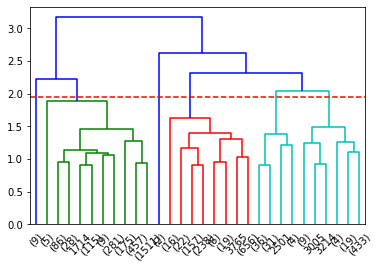

In [27]:
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=1.95, color='r', linestyle='--')

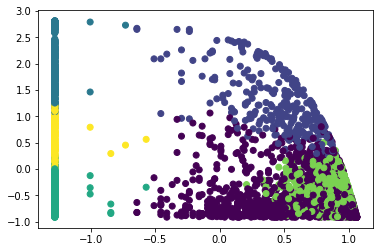

In [28]:
agg_ward = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
agg_ward.fit_predict(scaled)
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=agg_ward.labels_) 

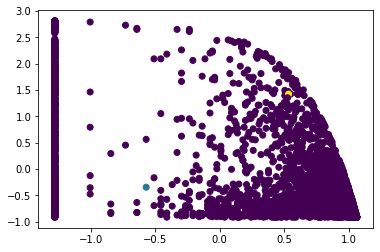

In [29]:
agg_single = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='single')  
agg_single.fit_predict(scaled)
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=agg_single.labels_) 

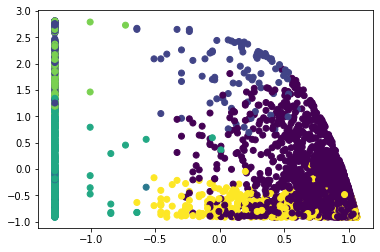

In [30]:
agg_comp = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete')  
agg_comp.fit_predict(scaled)
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=agg_comp.labels_) 

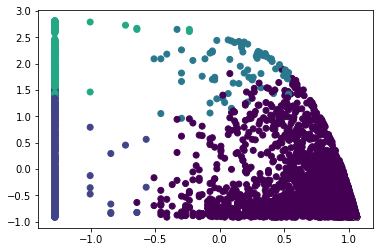

In [31]:
agg_avg = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')  
agg_avg.fit_predict(scaled)
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=agg_avg.labels_) 

## Comparisons

In [32]:
labels_kmeans = kmeans.labels_
labels_comp = agg_comp.labels_
labels_avg = agg_avg.labels_
labels_ward = agg_ward.labels_
labels_single = agg_single.labels_

kmean_sil = metrics.silhouette_score(data_scaled, labels_kmeans)
ward_sil = metrics.silhouette_score(data_scaled, labels_ward) 
avg_sil = metrics.silhouette_score(data_scaled,labels_avg)  
comp_sil = metrics.silhouette_score(data_scaled, labels_comp)
single_sil = metrics.silhouette_score(data_scaled, labels_single)

print(kmean_sil)
print(ward_sil)
print(avg_sil)
print(comp_sil)
print(single_sil)

0.3887480191621773
0.32488111838468087
0.4664711341938595
0.2226436079930406
-0.013672050906522236


# Extra: X-Means

In [33]:
from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES;

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer;

from pyclustering.cluster import cluster_visualizer;
from pyclustering.cluster.xmeans import xmeans, splitting_type;

In [34]:
# initial centers - optional parameter, if it is None, then random centers will be used by the algorithm.
# avoid random initial centers and initialize them using K-Means++ method

initial_centers = kmeans_plusplus_initializer(scaled, 2).initialize();
xmeans_instance = xmeans(scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);


### BAYESIAN_INFORMATION_CRITERION

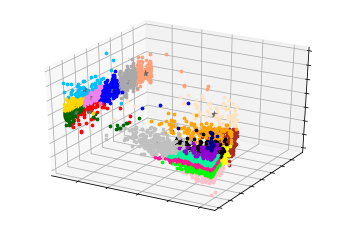

In [35]:
initial_centers = kmeans_plusplus_initializer(scaled, 2).initialize();
xmeans_instance = xmeans(scaled, initial_centers, criterion=splitting_type.BAYESIAN_INFORMATION_CRITERION, ccore=True);

# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters();
centers = xmeans_instance.get_centers()

# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

### MINIMUM_NOISELESS_DESCRIPTION_LENGTH

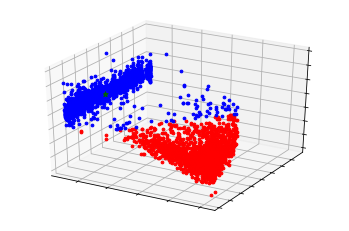

In [36]:
initial_centers = kmeans_plusplus_initializer(scaled, 2).initialize();
xmeans_instance = xmeans(scaled, initial_centers, criterion=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH, ccore=True);
# run cluster analysis
xmeans_instance.process();

# obtain results of clustering
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
# display allocated clusters
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, scaled);
visualizer.append_cluster(centers, None, marker = '*');
visualizer.show();

# SOM-SC

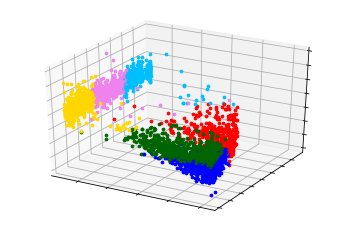

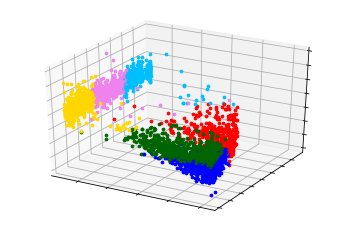

In [41]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.somsc import somsc
from pyclustering.samples.definitions import FCPS_SAMPLES

# Create instance of SOM-SC algorithm to allocated six clusters
somsc_instance = somsc(scaled, 6)
# Run cluster analysis and obtain results
somsc_instance.process()
clusters = somsc_instance.get_clusters()
# Visualize clustering results.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, scaled)
visualizer.show()